###Group 12 Project: Scott Stempak, Alex Imhoff, Samuel Chen, Felipe Zapater, Pranav Garg

In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, RocCurveDisplay, auc, classification_report
from sklearn.model_selection import train_test_split
from math import log2
from sklearn import tree
import graphviz
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import calibration_curve
!pip install shap
import shap

##EDA and Feature Engineering

In [2]:
#load dataset
df = pd.read_csv('Employee.csv', index_col = False)
df

,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,LeaveOrNot
0,Bachelors,2017,Bangalore,3,34,Male,No,0,0
1,Bachelors,2013,Pune,1,28,Female,No,3,1
2,Bachelors,2014,New Delhi,3,38,Female,No,2,0
3,Masters,2016,Bangalore,3,27,Male,No,5,1
4,Masters,2017,Pune,3,24,Male,Yes,2,1
...,...,...,...,...,...,...,...,...,...
4648,Bachelors,2013,Bangalore,3,26,Female,No,4,0
4649,Masters,2013,Pune,2,37,Male,No,2,1
4650,Masters,2018,New Delhi,3,27,Male,No,5,1
4651,Bachelors,2012,Bangalore,3,30,Male,Yes,2,0


We one hot encoded our categorical variables and created a new variable called 'Tenure' and removed the 'JoiningYear' column from our data set.

In [3]:
#one hot encoding categorical variables
df_encoded = pd.get_dummies(df, drop_first = False).astype(int)
#create 'Tenure' column
df_encoded['Tenure'] = 2018 - df['JoiningYear']
#drop 'JoiningYear' column
df_encoded.drop(columns = 'JoiningYear', inplace = True)
df_encoded

,PaymentTier,Age,ExperienceInCurrentDomain,LeaveOrNot,Education_Bachelors,Education_Masters,Education_PHD,City_Bangalore,City_New Delhi,City_Pune,Gender_Female,Gender_Male,EverBenched_No,EverBenched_Yes,Tenure
0,3,34,0,0,1,0,0,1,0,0,0,1,1,0,1
1,1,28,3,1,1,0,0,0,0,1,1,0,1,0,5
2,3,38,2,0,1,0,0,0,1,0,1,0,1,0,4
3,3,27,5,1,0,1,0,1,0,0,0,1,1,0,2
4,3,24,2,1,0,1,0,0,0,1,0,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4648,3,26,4,0,1,0,0,1,0,0,1,0,1,0,5
4649,2,37,2,1,0,1,0,0,0,1,0,1,1,0,5
4650,3,27,5,1,0,1,0,0,1,0,0,1,1,0,0
4651,3,30,2,0,1,0,0,1,0,0,0,1,0,1,6


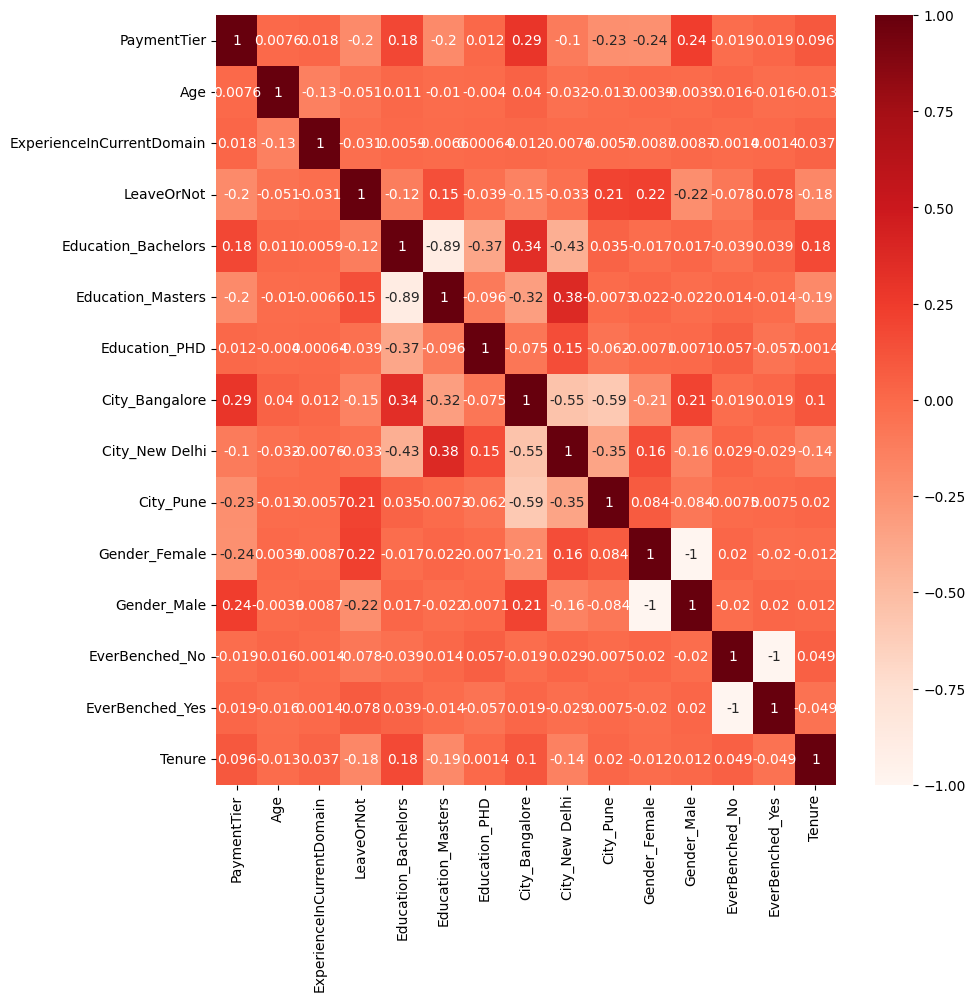

In [4]:
# NEW correlation map
#set get_dummies(drop_first) to False to see dropped variables' correlations with other dropped variables.
import seaborn as sns
plt.figure(figsize=(10,10))
cor_data = df_encoded
cor = cor_data.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

Nothing particularly correlated, except maybe Bangalore employees getting their bachelor's and New Delhi employees getting their Masters.

In [5]:
#dropping first category columns manually for consistency
#bachelors, bangalore, female, everbenched_no
df_encoded = df_encoded.drop(columns = ['Education_Bachelors', 'City_Bangalore', 'Gender_Female', 'EverBenched_No'])
df_encoded

,PaymentTier,Age,ExperienceInCurrentDomain,LeaveOrNot,Education_Masters,Education_PHD,City_New Delhi,City_Pune,Gender_Male,EverBenched_Yes,Tenure
0,3,34,0,0,0,0,0,0,1,0,1
1,1,28,3,1,0,0,0,1,0,0,5
2,3,38,2,0,0,0,1,0,0,0,4
3,3,27,5,1,1,0,0,0,1,0,2
4,3,24,2,1,1,0,0,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...
4648,3,26,4,0,0,0,0,0,0,0,5
4649,2,37,2,1,1,0,0,1,1,0,5
4650,3,27,5,1,1,0,1,0,1,0,0
4651,3,30,2,0,0,0,0,0,1,1,6


##Model Setup

In [6]:
#declare x and y variables
X = df_encoded.drop(columns = 'LeaveOrNot')
y = df_encoded['LeaveOrNot']

Stratified k-fold Cross Validation set-up

In [7]:
#set up code for stratified k-fold cross validation
skf = StratifiedKFold(n_splits=10,shuffle=True,random_state=42)


d_train_X = dict()
d_test_X = dict()
d_train_y = dict()
d_test_y = dict()

# Write your code here
current_fold = 1

for train_index, test_index in skf.split(X, y):
  X_train, X_test = X.iloc[train_index], X.iloc[test_index]
  y_train, y_test = y.iloc[train_index], y.iloc[test_index]

  d_train_X[current_fold] = X_train
  d_test_X[current_fold] = X_test
  d_train_y[current_fold] = y_train
  d_test_y[current_fold] = y_test

  current_fold += 1

In [8]:
# Observe the test data and verify that the target training is as equally distributed as possible
for key in d_test_y.keys():
    print(d_test_y[key].value_counts())

LeaveOrNot
0    306
1    160
Name: count, dtype: int64
LeaveOrNot
0    306
1    160
Name: count, dtype: int64
LeaveOrNot
0    306
1    160
Name: count, dtype: int64
LeaveOrNot
0    305
1    160
Name: count, dtype: int64
LeaveOrNot
0    305
1    160
Name: count, dtype: int64
LeaveOrNot
0    305
1    160
Name: count, dtype: int64
LeaveOrNot
0    305
1    160
Name: count, dtype: int64
LeaveOrNot
0    305
1    160
Name: count, dtype: int64
LeaveOrNot
0    305
1    160
Name: count, dtype: int64
LeaveOrNot
0    305
1    160
Name: count, dtype: int64


#Single Decision Tree Classifier



Hyperparameters:
*   criterion = 'gini'
*   max_depth = 3

Working on 1
Working on 2
Working on 3
Working on 4
Working on 5
Working on 6
Working on 7
Working on 8
Working on 9
Working on 10
The min, mean, and max TPR are: 0.42, 0.50, and 0.56
The min, mean, and max PPV are: 0.75, 0.82, and 0.88
The min, mean, and max ACC are: 0.76, 0.79, and 0.81


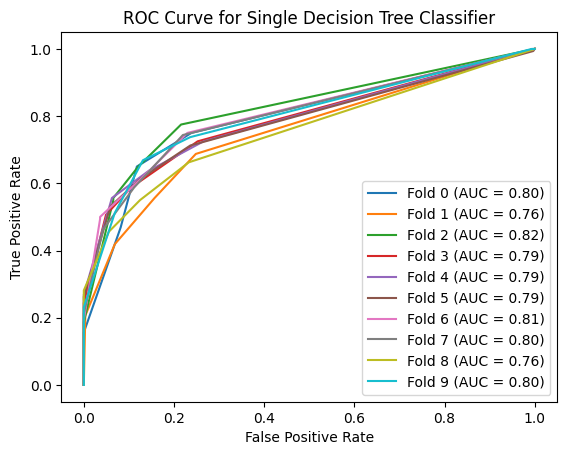

In [9]:
def train_and_plot_decision_tree_classifier():
  '''
  Trains an decision tree classifier on the previously manipulated data, evaluates it on the previously manipulated test data using cross validation,
  calculating accuracy, true positive rate, positive predictive value, false positive rate, and then plots the ROC curve.

    The Receiver Operating Characteristic (ROC) curve is a graphical plot that illustrates the diagnostic ability of a binary
    classifier system as its discrimination threshold is varied. The curve is plotted with the True Positive Rate against the
    False Positive Rate. The area under the curve (AUC) provides an aggregate measure of the model's performance across all
    possible classification thresholds.

    Args:
        None. Manipulating data from previous sections.

    Returns:
        array-like: Predicted labels for the test data.

    TODO:
        - Train the single tree classifier using the previously manipulated data.
        - Predict the decision function scores.
        - Compute the ROC values.
        - Compute the AUC.
        - Compute the Accuracy, TPR, FPR, and Positive Predictive Value
        - Plot the ROC curve and display the AUC.
        - Return the predicted labels from the 3rd fold in the variable 'y_hat_ab'.
  '''
  k = 10
  acc_ab = np.zeros(k)
  tpr_ab = np.zeros(k)
  ppv_ab = np.zeros(k)
  fpr_ab = np.zeros(k)

  fold_count = 0
  fig, ax = plt.subplots()

  # Complete this function
  for key in d_train_X.keys():
      print("Working on {}".format(key))

      X_train, X_test, y_train, y_test = d_train_X[key], d_test_X[key], d_train_y[key], d_test_y[key]

      # Train AdaBoost classifier
      clf = tree.DecisionTreeClassifier(criterion = 'gini', max_depth = 3, random_state = 42)
      clf.fit(X_train, y_train)

      # Predict the decision function scores
      y_pred = clf.predict(X_test)

      # Compute the ROC values
      y_scores = clf.predict_proba(X_test)[:, 1]
      fpr, tpr, _ = roc_curve(y_test, y_scores)

      # Compute the AUC (Area Under the Curve)
      roc_auc = auc(fpr, tpr)

      # Plot the ROC curve using RocCurveDisplay
      RocCurveDisplay.from_estimator(estimator = clf, X = X_test, y = y_test, ax = ax, name = f'Fold {fold_count}')

      # Accuracy
      acc_ab[fold_count] = np.sum(y_pred == y_test) / len(y_test)

      # True positive rate
      tpr_ab[fold_count] = np.sum((y_pred == 1) & (y_test == 1)) / np.sum(y_test == 1)

      # False positive rate
      fpr_ab[fold_count] = np.sum((y_pred == 1) & (y_test == 0)) / np.sum(y_test == 0)

      # Positive Predictive Value
      ppv_ab[fold_count] = np.sum((y_pred == 1) & (y_test == 1)) / np.sum(y_pred == 1) if np.sum(y_pred == 1) != 0 else 0

      fold_count += 1

      if key == 10:
        y_hat_ab = y_pred


  print('The min, mean, and max TPR are: {:.2f}, {:.2f}, and {:.2f}'.format(tpr_ab.min(), tpr_ab.mean(), tpr_ab.max()))
  print('The min, mean, and max PPV are: {:.2f}, {:.2f}, and {:.2f}'.format(ppv_ab.min(), ppv_ab.mean(), ppv_ab.max()))
  print('The min, mean, and max ACC are: {:.2f}, {:.2f}, and {:.2f}'.format(acc_ab.min(), acc_ab.mean(), acc_ab.max()))


  # plot the ROC Curve
  ax.set_xlabel('False Positive Rate')
  ax.set_ylabel('True Positive Rate')
  ax.set_title('ROC Curve for Single Decision Tree Classifier')
  ax.legend()
  plt.show()


  return y_hat_ab


y_hat_ab = train_and_plot_decision_tree_classifier()

#AdaBoost Classifier

Hyperparameters:
*   n_estimators = 100



Working on 1
Working on 2
Working on 3
Working on 4
Working on 5
Working on 6
Working on 7
Working on 8
Working on 9
Working on 10
The min, mean, and max TPR are: 0.44, 0.54, and 0.59
The min, mean, and max PPV are: 0.74, 0.81, and 0.85
The min, mean, and max ACC are: 0.76, 0.80, and 0.82


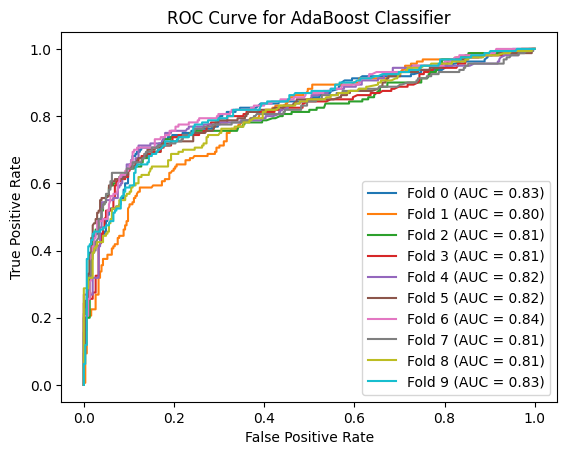

In [10]:
def train_and_plot_adaboost():
  '''
  Trains an AdaBoost classifier on the previously manipulated data, evaluates it on the previously manipulated test data using cross validation,
  calculating accuracy, true positive rate, positive predictive value, false positive rate, and then plots the ROC curve.

    The Receiver Operating Characteristic (ROC) curve is a graphical plot that illustrates the diagnostic ability of a binary
    classifier system as its discrimination threshold is varied. The curve is plotted with the True Positive Rate against the
    False Positive Rate. The area under the curve (AUC) provides an aggregate measure of the model's performance across all
    possible classification thresholds.

    Args:
        None. Manipulating data from previous sections.

    Returns:
        array-like: Predicted labels for the test data.

    TODO:
        - Train the AdaBoost classifier using the previously manipulated data.
        - Predict the decision function scores.
        - Compute the ROC values.
        - Compute the AUC.
        - Compute the Accuracy, TPR, FPR, and Positive Predictive Value
        - Plot the ROC curve and display the AUC.
        - Return the predicted labels from the 3rd fold in the variable 'y_hat_ab'.
  '''
  k = 10
  acc_ab = np.zeros(k)
  tpr_ab = np.zeros(k)
  ppv_ab = np.zeros(k)
  fpr_ab = np.zeros(k)

  fold_count = 0
  fig, ax = plt.subplots()

  # Complete this function
  for key in d_train_X.keys():
      print("Working on {}".format(key))

      X_train, X_test, y_train, y_test = d_train_X[key], d_test_X[key], d_train_y[key], d_test_y[key]

      # Train AdaBoost classifier
      ada_boost = AdaBoostClassifier(n_estimators = 100, random_state = 42)
      ada_boost.fit(X_train, y_train)

      # Predict the decision function scores
      y_pred = ada_boost.predict(X_test)

      # Compute the ROC values
      y_scores = ada_boost.predict_proba(X_test)[:, 1]
      fpr, tpr, _ = roc_curve(y_test, y_scores)

      # Compute the AUC (Area Under the Curve)
      roc_auc = auc(fpr, tpr)

      # Plot the ROC curve using RocCurveDisplay
      RocCurveDisplay.from_estimator(estimator = ada_boost, X = X_test, y = y_test, ax = ax, name = f'Fold {fold_count}')

      # Accuracy
      acc_ab[fold_count] = np.sum(y_pred == y_test) / len(y_test)

      # True positive rate
      tpr_ab[fold_count] = np.sum((y_pred == 1) & (y_test == 1)) / np.sum(y_test == 1)

      # False positive rate
      fpr_ab[fold_count] = np.sum((y_pred == 1) & (y_test == 0)) / np.sum(y_test == 0)

      # Positive Predictive Value
      ppv_ab[fold_count] = np.sum((y_pred == 1) & (y_test == 1)) / np.sum(y_pred == 1) if np.sum(y_pred == 1) != 0 else 0

      fold_count += 1

      if key == 10:
        y_hat_ab = y_pred


  print('The min, mean, and max TPR are: {:.2f}, {:.2f}, and {:.2f}'.format(tpr_ab.min(), tpr_ab.mean(), tpr_ab.max()))
  print('The min, mean, and max PPV are: {:.2f}, {:.2f}, and {:.2f}'.format(ppv_ab.min(), ppv_ab.mean(), ppv_ab.max()))
  print('The min, mean, and max ACC are: {:.2f}, {:.2f}, and {:.2f}'.format(acc_ab.min(), acc_ab.mean(), acc_ab.max()))


  # plot the ROC Curve
  ax.set_xlabel('False Positive Rate')
  ax.set_ylabel('True Positive Rate')
  ax.set_title('ROC Curve for AdaBoost Classifier')
  ax.legend()
  plt.show()


  return y_hat_ab


y_hat_ab = train_and_plot_adaboost()

#Random Forest Classifier

Hyperparameters:

*   criterion = 'gini'
*   n_estimators = 100
*   max_depth = 5
*   max_features = 'sqrt'
*   min_samples_leaf = 2
*   min_samples_split = 10



Working on 1
Working on 2
Working on 3
Working on 4
Working on 5
Working on 6
Working on 7
Working on 8
Working on 9
Working on 10
The min, mean, and max TPR are: 0.49, 0.55, and 0.62
The min, mean, and max PPV are: 0.89, 0.93, and 0.96
The min, mean, and max ACC are: 0.81, 0.83, and 0.85


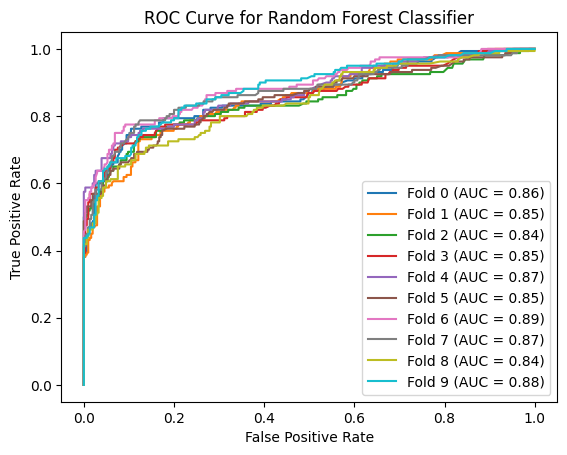

In [11]:
def train_and_plot_randomforest():
    '''
    Trains a Random Forest classifier on the provided training data and plots the ROC curve
    for each fold in the cross-validation process.

    The function uses a Random Forest with specified hyperparameters. For each fold in the
    cross-validation, the function computes accuracy, TPR, PPV, and FPR, and plots the
    corresponding ROC curve. The ROC curve is generated using the class probabilities
    for the positive class from the Random Forest classifier.

    Parameters:
    None. The function relies on globally defined datasets and split indices.

    Returns:
    y_hat : numpy array
        Predictions for the instances in the test set for the 3rd fold.

    Note:
    This function assumes that certain variables like training and test sets are
    defined in the global namespace.
    '''
    epsilon = 1e-08
    k = 10
    acc_rf = np.zeros(k)
    tpr_rf = np.zeros(k)
    ppv_rf = np.zeros(k)
    fpr_rf = np.zeros(k)

    fold_count = 0
    fig, ax = plt.subplots()

    # Complete this function
    for key in d_train_X.keys():
        print("Working on {}".format(key))

        X_train, X_test, y_train, y_test = d_train_X[key], d_test_X[key], d_train_y[key], d_test_y[key]

        # Train RandomForest classifier
        random_forest = RandomForestClassifier(criterion = "gini", n_estimators = 100, max_depth = 5, max_features = "sqrt", min_samples_leaf = 2, min_samples_split = 10,  random_state = 42)
        random_forest.fit(X_train, y_train)

        # Get the probability scores for the positive class
        y_scores = random_forest.predict_proba(X_test)[:, 1]

        # Compute the ROC values
        fpr, tpr, _ = roc_curve(y_test, y_scores)

        # Compute the AUC (Area Under the Curve)
        roc_auc = auc(fpr, tpr)

        # Plot the ROC curve using RocCurveDisplay
        RocCurveDisplay.from_estimator(estimator = random_forest, X = X_test, y = y_test, ax = ax, name = f'Fold {fold_count}')

        # Accuracy
        y_pred = random_forest.predict(X_test)
        acc_rf[fold_count] = np.sum(y_pred == y_test) / len(y_test)

        # True positive rate
        tpr_rf[fold_count] = np.sum((y_pred == 1) & (y_test == 1)) / np.sum(y_test == 1)

        # False positive rate
        fpr_rf[fold_count] = np.sum((y_pred == 1) & (y_test == 0)) / np.sum(y_test == 0)

        # Positive Predictive Value                                  # add epsilon to avoid division by zero
        ppv_rf[fold_count] = np.sum((y_pred == 1) & (y_test == 1)) / (np.sum(y_pred == 1) + epsilon)

        fold_count += 1

        if key == 10:
          y_hat_rf = y_pred

    print('The min, mean, and max TPR are: {:.2f}, {:.2f}, and {:.2f}'.format(tpr_rf.min(), tpr_rf.mean(), tpr_rf.max()))
    print('The min, mean, and max PPV are: {:.2f}, {:.2f}, and {:.2f}'.format(ppv_rf.min(), ppv_rf.mean(), ppv_rf.max()))
    print('The min, mean, and max ACC are: {:.2f}, {:.2f}, and {:.2f}'.format(acc_rf.min(), acc_rf.mean(), acc_rf.max()))

    #plot the ROC curve
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC Curve for Random Forest Classifier')
    ax.legend()
    plt.show()


    return y_hat_rf


y_hat_rf = train_and_plot_randomforest()

#Grid Search to find optimal random forest hyperparameters

In [12]:
# gridsearchCV for hyperparamterer optimization
# Looks like randomForest is performing a little bit better, so we will try to optimize its parameters
param_grid = {
    'n_estimators': [100, 150, 200, 250, 500],
    'max_depth': [4, 5, 6, 7],
    'min_samples_split': [5, 10, 20],
    'min_samples_leaf': [2, 5, 10],
    'max_features': ['sqrt']
}

In [13]:
rf_cv = RandomForestClassifier(random_state = 42)

grid_search = GridSearchCV(estimator=rf_cv, param_grid=param_grid,
                           scoring='f1', cv=2, verbose=1, n_jobs=-1)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

Fitting 2 folds for each of 180 candidates, totalling 360 fits


GridSearchCV(cv=2, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [4, 5, 6, 7], 'max_features': ['sqrt'],
                         'min_samples_leaf': [2, 5, 10],
                         'min_samples_split': [5, 10, 20],
                         'n_estimators': [100, 150, 200, 250, 500]},
             scoring='f1', verbose=1)

In [14]:
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best parameters: {best_params}")
print(f"Best cross-validation score: {best_score}")

Best parameters: {'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 250}
Best cross-validation score: 0.7448563385830003


#Tuned Random Forest Classifier

Hyperparameters:

*   criterion = 'gini'
*   n_estimators = 250
*   max_depth = 7
*   max_features = 'sqrt'
*   min_samples_leaf = 2
*   min_samples_split = 5



Working on 1
Working on 2
Working on 3
Working on 4
Working on 5
Working on 6
Working on 7
Working on 8
Working on 9
Working on 10
The min, mean, and max TPR are: 0.61, 0.64, and 0.69
The min, mean, and max PPV are: 0.86, 0.90, and 0.95
The min, mean, and max ACC are: 0.84, 0.85, and 0.87


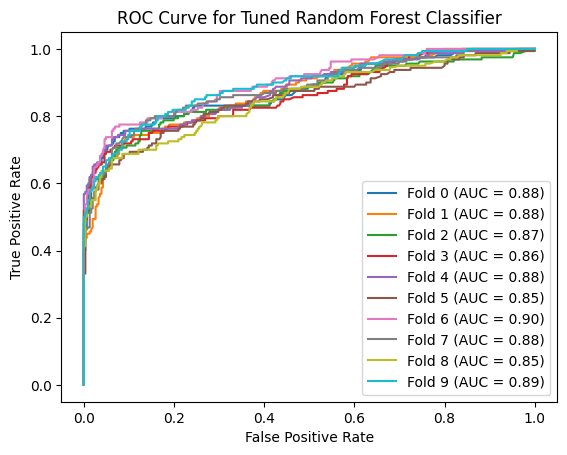

In [15]:
def train_and_plot_tuned_randomforest():
    '''
    Trains a Random Forest classifier on the provided training data and plots the ROC curve
    for each fold in the cross-validation process.

    The function uses a Random Forest with specified hyperparameters. For each fold in the
    cross-validation, the function computes accuracy, TPR, PPV, and FPR, and plots the
    corresponding ROC curve. The ROC curve is generated using the class probabilities
    for the positive class from the Random Forest classifier.

    Parameters:
    None. The function relies on globally defined datasets and split indices.

    Returns:
    y_hat : numpy array
        Predictions for the instances in the test set for the 3rd fold.

    Note:
    This function assumes that certain variables like training and test sets are
    defined in the global namespace.
    '''
    epsilon = 1e-08
    k = 10
    acc_rf = np.zeros(k)
    tpr_rf = np.zeros(k)
    ppv_rf = np.zeros(k)
    fpr_rf = np.zeros(k)

    fold_count = 0
    fig, ax = plt.subplots()

    # Complete this function
    for key in d_train_X.keys():
        print("Working on {}".format(key))

        X_train, X_test, y_train, y_test = d_train_X[key], d_test_X[key], d_train_y[key], d_test_y[key]

        # Train RandomForest classifier
        random_forest = RandomForestClassifier(criterion = "gini", n_estimators = 250, max_depth = 7, max_features = "sqrt", min_samples_leaf = 2, min_samples_split = 5,  random_state = 42)
        random_forest.fit(X_train, y_train)

        # Get the probability scores for the positive class
        y_scores = random_forest.predict_proba(X_test)[:, 1]

        # Compute the ROC values
        fpr, tpr, _ = roc_curve(y_test, y_scores)

        # Compute the AUC (Area Under the Curve)
        roc_auc = auc(fpr, tpr)

        # Plot the ROC curve using RocCurveDisplay
        RocCurveDisplay.from_estimator(estimator = random_forest, X = X_test, y = y_test, ax = ax, name = f'Fold {fold_count}')

        # Accuracy
        y_pred = random_forest.predict(X_test)
        acc_rf[fold_count] = np.sum(y_pred == y_test) / len(y_test)

        # True positive rate
        tpr_rf[fold_count] = np.sum((y_pred == 1) & (y_test == 1)) / np.sum(y_test == 1)

        # False positive rate
        fpr_rf[fold_count] = np.sum((y_pred == 1) & (y_test == 0)) / np.sum(y_test == 0)

        # Positive Predictive Value                                  # add epsilon to avoid division by zero
        ppv_rf[fold_count] = np.sum((y_pred == 1) & (y_test == 1)) / (np.sum(y_pred == 1) + epsilon)

        fold_count += 1

        if key == 10:
          y_hat_rf = y_pred

    print('The min, mean, and max TPR are: {:.2f}, {:.2f}, and {:.2f}'.format(tpr_rf.min(), tpr_rf.mean(), tpr_rf.max()))
    print('The min, mean, and max PPV are: {:.2f}, {:.2f}, and {:.2f}'.format(ppv_rf.min(), ppv_rf.mean(), ppv_rf.max()))
    print('The min, mean, and max ACC are: {:.2f}, {:.2f}, and {:.2f}'.format(acc_rf.min(), acc_rf.mean(), acc_rf.max()))

    #plot the ROC curve
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC Curve for Tuned Random Forest Classifier')
    ax.legend()
    plt.show()


    return y_hat_rf


y_hat_tuned_rf = train_and_plot_tuned_randomforest()

#Model Evaluation

In [32]:
#rerunning model out of cross validation function
#declare x and y variables
X = df_encoded.drop(columns = 'LeaveOrNot')
y = df_encoded['LeaveOrNot']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

rf_best = RandomForestClassifier(n_estimators = 250, max_depth = 7, max_features = 'sqrt', min_samples_leaf = 2, min_samples_split = 5)
rf_best.fit(X_train, y_train)
rf_best_preds = rf_best.predict(X_test)

In [33]:
#classification report - gives precision, recall, and f1 score for each class
print(classification_report(y_test, rf_best_preds))

              precision    recall  f1-score   support

           0       0.84      0.98      0.91       610
           1       0.94      0.65      0.77       321

    accuracy                           0.87       931
   macro avg       0.89      0.81      0.84       931
weighted avg       0.88      0.87      0.86       931



#Calibration Plot

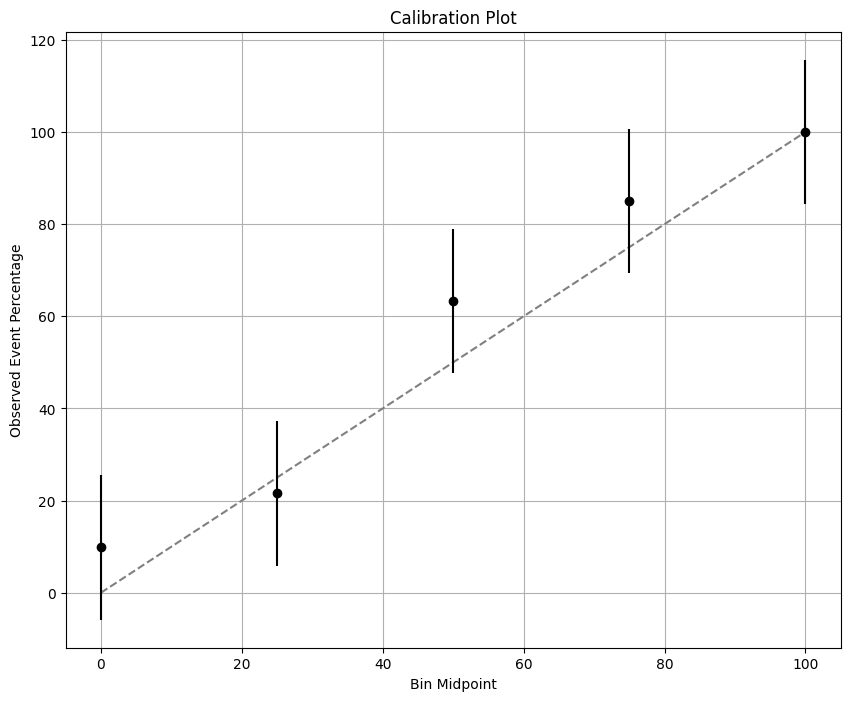

In [34]:
#predicting probabilities, not the classes (between 0 and 1, not just 0 or 1)
rf_best_probs = rf_best.predict_proba(X_test)[:, 1]

prob_true, prob_pred = calibration_curve(y_test, rf_best_probs, n_bins=5)
# Calculate bin midpoints
bin_midpoints = np.linspace(0, 100, len(prob_true))
# Plot the calibration plot
plt.figure(figsize=(10, 8))
plt.plot(bin_midpoints, bin_midpoints, linestyle='--', color='gray')
plt.errorbar(bin_midpoints, prob_true * 100, yerr=np.std(prob_true * 100) / np.sqrt(len(prob_true)), fmt='o', color='black')
plt.xlabel('Bin Midpoint')
plt.ylabel('Observed Event Percentage')
plt.title('Calibration Plot')
plt.grid(True)
plt.show()

#Feature Importance

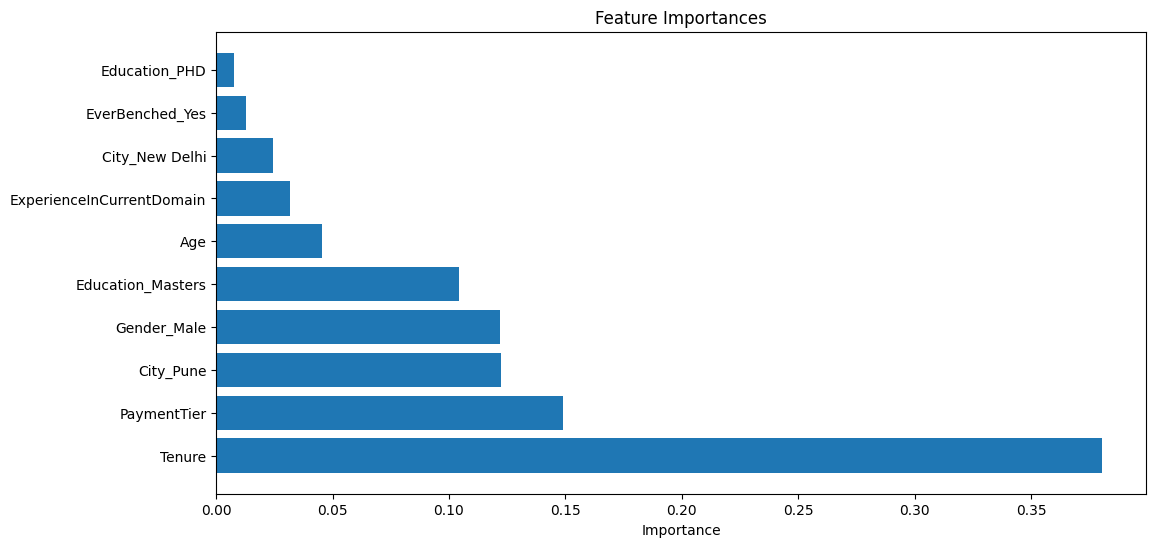

In [35]:
importances = rf_best.feature_importances_

# Sort the importances in descending order
indices = np.argsort(importances)[::-1]
sorted_feature_names = [X_train.columns[i] for i in indices]

# Plot the feature importances
plt.figure(figsize=(12, 6))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], align="center")
plt.yticks(range(len(indices)), sorted_feature_names)
plt.xlabel("Importance")
plt.show()

#Shapley Values

In [37]:
explainer = shap.Explainer(rf_best, X_train, feature_names=X.columns)

shap_values = explainer(X_test)

print("Shape of SHAP values:", shap_values.values.shape)
print("SHAP values for the first sample:", shap_values.values[0])

# Check the base values (expected values)
print("Base values:", shap_values.base_values[0])

# Ensure that the feature names match the columns of X_test
print("Feature names from SHAP:", shap_values.feature_names)
print("Columns in X_test:", X_test.columns)

 98%|===================| 1822/1862 [01:00<00:01]       

Shape of SHAP values: (931, 10, 2)
SHAP values for the first sample: [[ 0.03787466 -0.03787466]
 [-0.00491438  0.00491438]
 [-0.00996908  0.00996908]
 [ 0.02971119 -0.02971119]
 [-0.00167339  0.00167339]
 [-0.01282354  0.01282354]
 [ 0.05898672 -0.05898672]
 [-0.05799005  0.05799005]
 [ 0.00109297 -0.00109297]
 [ 0.05854004 -0.05854005]]
Base values: [0.68948761 0.31051239]
Feature names from SHAP: ['PaymentTier', 'Age', 'ExperienceInCurrentDomain', 'Education_Masters', 'Education_PHD', 'City_New Delhi', 'City_Pune', 'Gender_Male', 'EverBenched_Yes', 'Tenure']
Columns in X_test: Index(['PaymentTier', 'Age', 'ExperienceInCurrentDomain', 'Education_Masters',
       'Education_PHD', 'City_New Delhi', 'City_Pune', 'Gender_Male',
       'EverBenched_Yes', 'Tenure'],
      dtype='object')


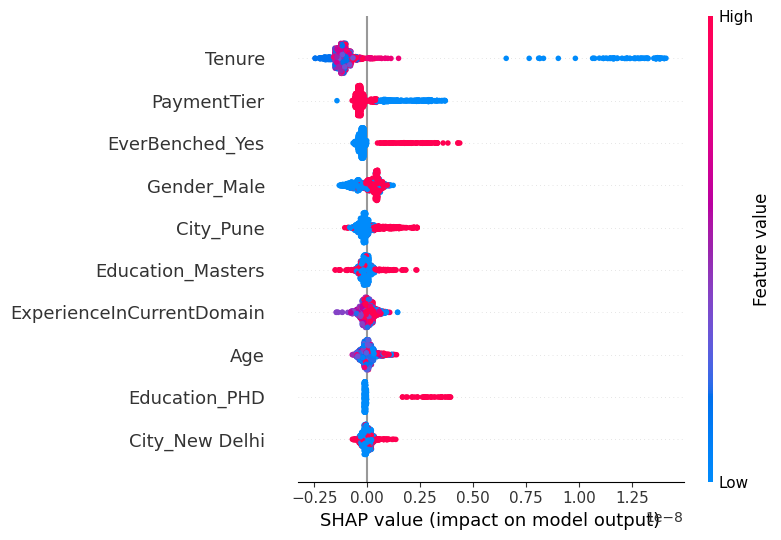

In [44]:
shap_values_avg =(shap_values.values).mean(axis=-1)

# Plot the SHAP summary plot
shap.summary_plot(shap_values_avg, X_test, feature_names=X_test.columns, max_display=12)

#would have to explain how I took the abs value and mean to overcome the problem of displaying the plot but this is v interpretable

# main insight: if we identify an employee to be of low tenure (just started at the company)
# who are going to leave according to the model (classify as 1)
# we think that you should invest in them more